### Analyzie coeffficient of partial determination for entire population, and split by regions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from utils.glm_constants import *

In [2]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
ALPHA = 0.05
sessions = pd.read_pickle(SESSIONS_PATH)

In [4]:
# REGION = "Hippocampus/MTL"
# REGION = "hippocampal_formation (HF)"
# REGION = "orbital_frontal_cortex (OFC)"
REGION = "all"
units = spike_utils.get_unit_positions(sessions)
region_units = units
# region_units = units[units.manual_structure == REGION]
# region_units = units[units.structure_level3 == REGION]
# region_units = units[units.structure_level2 == REGION]

In [4]:
def get_res_per_session(row):
    session = row.session_name
    # separate_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_fr_50_feature_rpe_separate.pickle"))
    separate_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_{MODE}_{INTERVAL_SIZE}_{MODEL}_feature_rpe_separate.pickle"))

    separate_res["TimeIdxs"] = (separate_res["TimeBins"] * 20).astype(int)
    print(separate_res.columns)
    separate_res = separate_res.rename(columns={"score": "separate_score"})

    # interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_fr_50_feature_rpe_interaction.pickle"))
    interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_{MODE}_{INTERVAL_SIZE}_{MODEL}_feature_rpe_interaction.pickle"))

    interaction_res["TimeIdxs"] = (interaction_res["TimeBins"] * 20).astype(int)
    interaction_res = interaction_res.rename(columns={"score": "interaction_score"})

    # shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_shuffles.pickle"))        
    # shuffled_res["TimeIdxs"] = (shuffled_res["TimeBins"] * 20).astype(int)

    # sig_stats = glm_utils.calculate_sig_stats(shuffled_res, ALPHA, 1)
    # sig_stats["TimeIdxs"] = (sig_stats["TimeBins"] * 20).astype(int)

    merged = pd.merge(separate_res, interaction_res, on=["UnitID", "TimeIdxs"])
    # merged = pd.merge(merged, sig_stats, on=["UnitID", "TimeIdxs"])

    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)

    with_pos = pd.merge(merged, pos, on=["UnitID"])
    with_pos["PseudoUnitID"] = int(session) * 100 + with_pos["UnitID"]
    return with_pos[["PseudoUnitID", "TimeIdxs", "separate_score", "interaction_score", "manual_structure"]]
    # return with_pos[["PseudoUnitID", "TimeBins", "TimeIdxs", "separate_score", "interaction_score", "sig_bound", "manual_structure"]]

In [12]:
unit_res = pd.concat(sessions.apply(get_res_per_session, axis=1).values).reset_index(drop=True)
# unit_res = unit_res[unit_res.PseudoUnitID.isin(region_units.PseudoUnitID)]

Index(['UnitID', 'TimeBins', 0, 'TimeIdxs'], dtype='object')


KeyError: "['separate_score', 'interaction_score'] not in index"

In [14]:
unit_res["additional_score"] = 1 - (1 - unit_res["interaction_score"]) / (1 - unit_res["separate_score"])
# unit_res["sig_additional_score"] = 1 - (1 - unit_res["sig_bound"]) / (1 - unit_res["separate_score"])

In [15]:
unit_res

,PseudoUnitID,TimeIdxs,separate_score,interaction_score,manual_structure,additional_score
0,2018070900,0,0.011498,0.039695,Claustrum,0.028525
1,2018070900,1,0.015730,0.047294,Claustrum,0.032068
2,2018070900,2,0.010667,0.041018,Claustrum,0.030679
3,2018070900,3,0.009442,0.037227,Claustrum,0.028050
4,2018070900,4,0.008124,0.031603,Claustrum,0.023672
...,...,...,...,...,...,...
42331,2018091029,51,0.037685,0.062385,Amygdala,0.025667
42332,2018091029,52,0.027830,0.055467,Amygdala,0.028428
42333,2018091029,53,0.023998,0.047148,Amygdala,0.023719
42334,2018091029,54,0.022169,0.044090,Amygdala,0.022417


/tmp/ipykernel_3851415/3763582492.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avged = region_res.groupby("TimeIdxs").mean().reset_index()
/tmp/ipykernel_3851415/3763582492.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avged = region_res.groupby("TimeIdxs").mean().reset_index()
/tmp/ipykernel_3851415/3763582492.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avged = region_res.groupby("TimeIdxs").mean

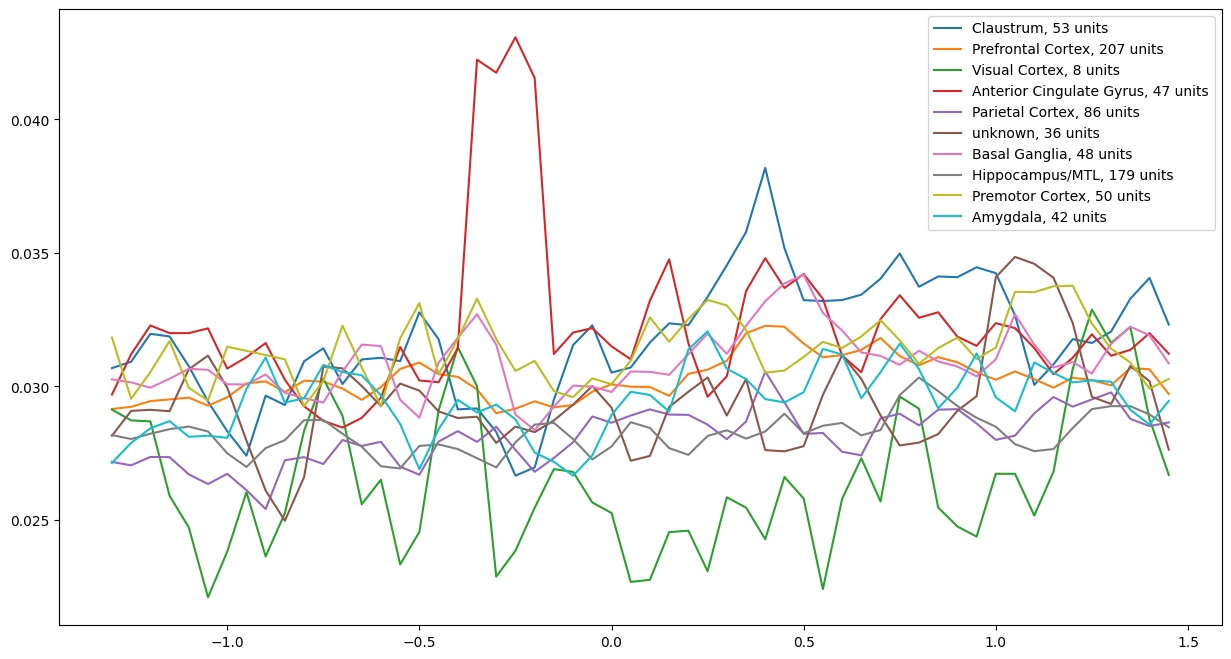

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
time = np.arange(-1.3, 1.5, 0.05)

for region in unit_res.manual_structure.unique():
    region_res = unit_res[unit_res.manual_structure == region]
    avged = region_res.groupby("TimeIdxs").mean().reset_index()
    ax.plot(time, avged.additional_score, label=f"{region}, {len(region_res.PseudoUnitID.unique())} units")
ax.legend()


In [63]:
avged = unit_res.groupby("TimeBins")["additional_score", "sig_additional_score"].mean().reset_index()

/tmp/ipykernel_3629507/3452084166.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avged = unit_res.groupby("TimeBins")["additional_score", "sig_additional_score"].mean().reset_index()


Text(0.5, 1.0, 'all, 756 units')

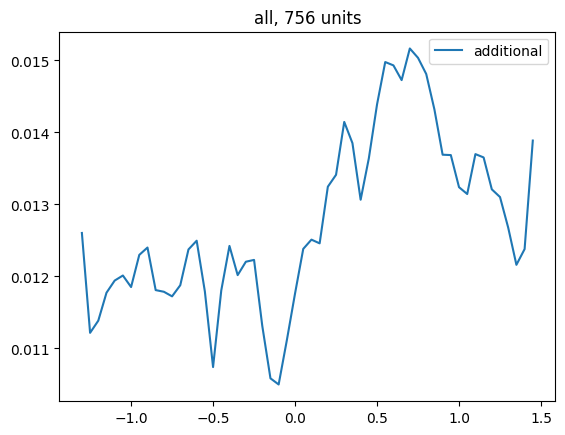

In [45]:
fig, ax = plt.subplots()
time = np.arange(-1.3, 1.5, 0.05)
ax.plot(time, avged.additional_score, label="additional")
# ax.plot(time, avged.sig_additional_score, label="sig bound")
ax.legend()
ax.set_title(f"{REGION}, {len(unit_res.PseudoUnitID.unique())} units")

### SOme debugging code

In [9]:
import utils.io_utils as io_utils
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_{num_bins_smooth}_smooth.pickle"

FEATURE_DIMS = ["Color", "Shape", "Pattern"]

sess_name = "20180802"
data = io_utils.load_rpe_sess_beh_and_frs(sess_name, beh_path=SESS_BEHAVIOR_PATH, fr_path=SESS_SPIKES_PATH)
separate_input_cols = ["RPEGroup"] + FEATURE_DIMS
# separate_ols = glm_utils.fit_glm_for_data(data, separate_input_cols, model_type="Linear", include_predictions=True)
# separate_ridge = glm_utils.fit_glm_for_data(data, separate_input_cols, model_type="Ridge", include_predictions=False)

reses = []
for mode in ["FiringRate", "SpikeCounts"]: 
    res = glm_utils.fit_glm_for_data(data, separate_input_cols, mode=mode, model_type=MODEL, include_predictions=True)
    res[mode] = res.actual - res.predicted
    reses.append(res[["UnitID", "TimeBins", "TrialNumber", mode]])
merged = pd.merge(reses[0], reses[1], on=["UnitID", "TimeBins", "TrialNumber"])

All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping fitting
All 0 frs, skipping 

In [10]:
merged

,UnitID,TimeBins,TrialNumber,FiringRate,SpikeCounts
0,0,0.00,35,4.578864,0.250000
1,0,0.00,36,-14.500000,-0.687500
2,0,0.00,37,-2.181702,0.234375
3,0,0.00,38,-12.737550,-0.718750
4,0,0.00,39,-14.250000,-0.703125
...,...,...,...,...,...
4397227,45,2.75,1738,-0.058594,0.004822
4397228,45,2.75,1739,-0.248047,-0.017334
4397229,45,2.75,1740,-0.250000,-0.014160
4397230,45,2.75,1741,-0.215820,-0.006775


In [12]:
print(len(merged.UnitID.unique()) * len(merged.TimeBins.unique()) * len(merged.TrialNumber.unique()))

4397232


In [7]:
separate_ols[["UnitID", "TimeBins", "TrialNumber", MODE]]

,UnitID,TimeBins,TrialNumber,FiringRate
0,0,0.00,35,4.578864
1,0,0.00,36,-14.500000
2,0,0.00,37,-2.181702
3,0,0.00,38,-12.737550
4,0,0.00,39,-14.250000
...,...,...,...,...
4397227,45,2.75,1738,-0.058594
4397228,45,2.75,1739,-0.248047
4397229,45,2.75,1740,-0.250000
4397230,45,2.75,1741,-0.215820


In [9]:
merged = pd.merge(separate_ols, separate_ridge, on=["UnitID", "TimeBins"], suffixes=("_ols", "_ridge"))

In [10]:
merged["score_diff"] = merged.score_ols - merged.score_ridge

In [11]:
merged.loc[merged.score_ridge.idxmax()]

UnitID         43.000000
TimeBins        1.500000
score_ols       0.688332
score_ridge     0.689654
score_diff     -0.001321
Name: 2438, dtype: float64

In [12]:
merged.score_diff

0      -0.002622
1      -0.003048
2      -0.002023
3      -0.002393
4      -0.001710
          ...   
2571   -0.000103
2572   -0.000254
2573   -0.000105
2574   -0.000144
2575   -0.000111
Name: score_diff, Length: 2576, dtype: float64